In [1]:
from preprocess import * 
from paper_emb import *
from graph import *
from load import *
import os
import re
from tqdm import tqdm
from os.path import join
import pinyin
import unicodedata
import json
import codecs
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
import torch
from sklearn.decomposition import PCA

C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Build folders (or skip)

## Get metadata (from pubinfo) and co-relations (from rawpub)

In [2]:
pubinfo_train = read_pubinfo('train')
pubinfo_valid = read_pubinfo('valid')
pubinfo_test = read_pubinfo('test')
rawpub_train = read_raw_pubs('train')
rawpub_valid = read_raw_pubs('valid')
rawpub_test = read_raw_pubs('test')
dump_name_pubs()
dump_features_relations_to_file()

100%|██████████| 80/80 [00:03<00:00, 24.75it/s]
160it [00:07, 21.89it/s]


Finish train data extracted.


80it [00:04, 16.86it/s]


Finish valid data extracted.


80it [00:04, 18.06it/s]

Finish test data extracted.
All paper features extracted.


## Get paper embeddings (from metadata)

In [3]:
ft_dim = 256
dump_corpus()
train_w2v_model(ft_dim)
dump_paper_emb(model_name=f"w2v_{ft_dim}", ft_dim=ft_dim)

100%|██████████| 73835/73835 [00:04<00:00, 18195.75it/s]


File c:\Users\aless\OneDrive\Desktop\BOND\data_train.json text extracted.


100%|██████████| 46287/46287 [00:02<00:00, 17871.10it/s]


File c:\Users\aless\OneDrive\Desktop\BOND\data_valid.json text extracted.


100%|██████████| 46020/46020 [00:02<00:00, 16673.55it/s]


File c:\Users\aless\OneDrive\Desktop\BOND\data_test.json text extracted.
Finish word2vec training.


160it [00:08, 17.87it/s]
80it [00:06, 13.27it/s]
80it [00:06, 12.62it/s]


### We can try to visualize the embedding space for some qualitative analysis

In [ ]:
path = 'paper_emb/train'
names = ['bin_yu']
embeddings = {}

for name in names:
    file_path = os.path.join(path, name, "ptext_emb.pkl")
    with open(file_path, "rb") as f:
        embeddings[name] = pickle.load(f)

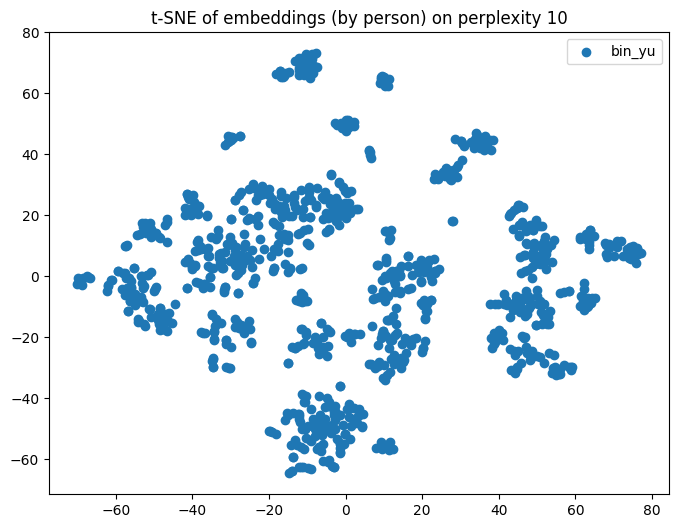

In [11]:
X = []
labels = []

for person, inner_dict in embeddings.items():
    for key, vector in inner_dict.items():
        X.append(vector)
        labels.append(person)  # cluster by person

X = np.array(X)
perplexity=10
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
X_tsne = tsne.fit_transform(X)
# plot
plt.figure(figsize=(8,6))
people = list(embeddings.keys())
for person in people:
    idxs = [i for i, lbl in enumerate(labels) if lbl == person]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], label=person)

plt.legend()
plt.title(f"t-SNE of embeddings (by person) on perplexity {perplexity}")
plt.show()


# Now we should be able to build and load the graph

In [2]:
build_graph()

preprocess dataset:  test


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


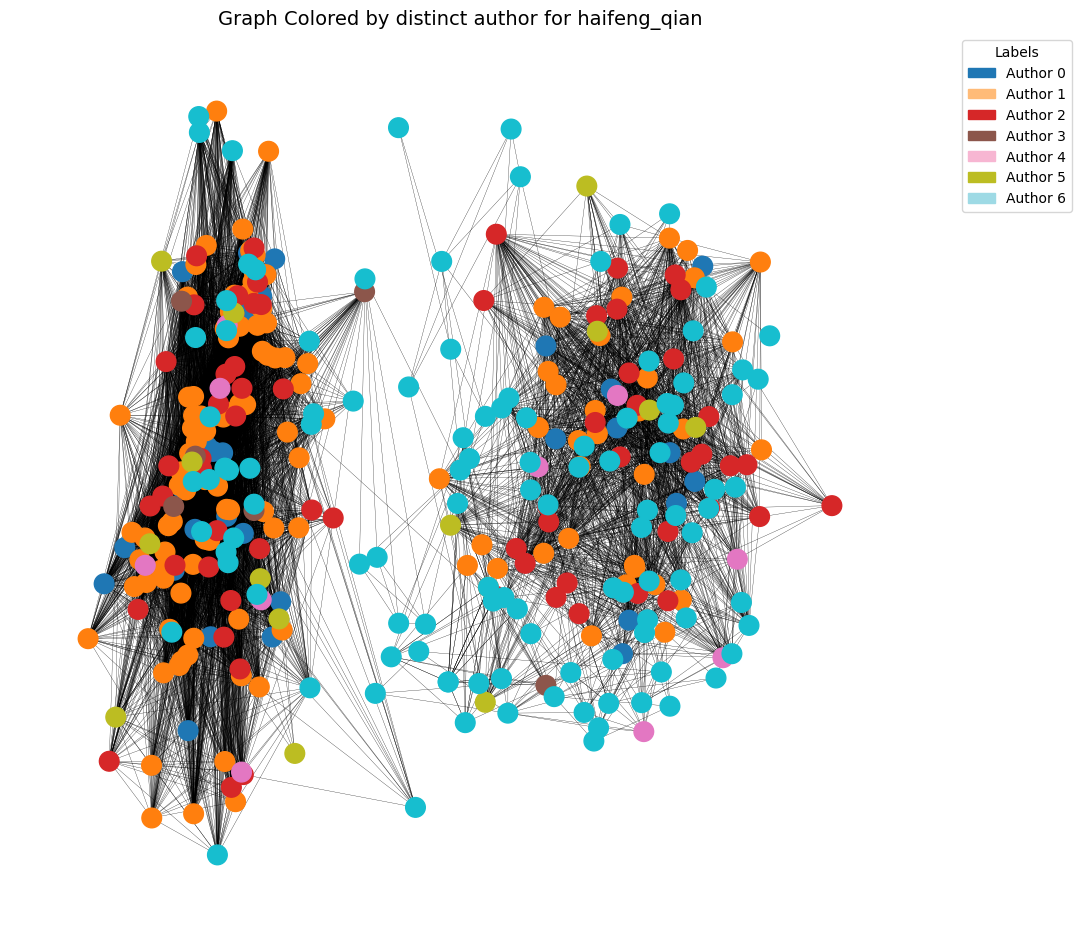

In [3]:
name = 'haifeng_qian'

label, ft_tensor, data = load_graph(name, mode='valid')

# Viz

# If label is a tensor, convert to numpy first
if isinstance(label, torch.Tensor):
    label = label.numpy()

# If label is an array-like instead of dict, turn into {node_id: class}
if not isinstance(label, dict):
    label = {i: str(label[i]) for i in range(len(label))}


num_nodes, num_features = ft_tensor.shape

# Reduce to 2D if needed
if num_features > 2:
    ft_2d = PCA(n_components=2).fit_transform(ft_tensor)
else:
    ft_2d = ft_tensor

# Extract edges
if hasattr(data, "edge_index"):
    edge_index = data.edge_index
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.numpy()
    edges = list(zip(edge_index[0], edge_index[1]))
else:
    edges = data

G = nx.Graph()
G.add_edges_from(edges)

# Positions from features
pos = {i: ft_2d[i] for i in range(len(ft_2d))}

# Convert string labels in dict → integers for coloring
unique_classes = sorted(set(label.values()), key=int)  # all class names
class_to_int = {c: i for i, c in enumerate(unique_classes)}
node_colors = [class_to_int[label[i]] for i in range(len(G.nodes))]

# Draw
plt.figure(figsize=(9, 9))
nodes = nx.draw(
    G, pos,
    node_color=node_colors,
    cmap=plt.cm.tab10,   # tab20 gives up to 20 distinct colors
    with_labels=False,   # no text on nodes
    node_size=200,
    edge_color="black",
    width=0.2
)

# Add legend for classes
from matplotlib.patches import Patch
handles = [Patch(color=plt.cm.tab20(class_to_int[c] / max(1, len(unique_classes)-1)),
                 label=f"Author {c}") for c in unique_classes]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")

plt.title(f"Graph Colored by distinct author for {name}", fontsize=14)
plt.show()